In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/dk-dataset.zip /content

In [ ]:
!unzip dk-dataset.zip

In [ ]:
!mv dataset/train/positive dataset/train/1

In [ ]:
!mv dataset/train/negative dataset/train/0

In [ ]:
!mkdir dataset/test/0

In [ ]:
!mv dataset/test/* dataset/test/0

mv: cannot move 'dataset/test/0' to a subdirectory of itself, 'dataset/test/0/0'


In [ ]:
test_data = torchvision.datasets.ImageFolder(root ='dataset/test', transform = transform)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [ ]:
len(train_data)

8582

In [ ]:
%%capture
BATCH_SIZE = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((100,100))])


## transformations

## download and load training dataset
train_data = torchvision.datasets.ImageFolder(root ='dataset/train', transform = transform)
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
test_data = torchvision.datasets.ImageFolder(root ='dataset/test', transform = transform)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

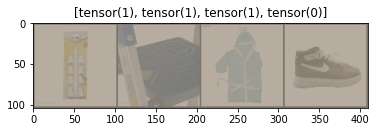

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 100, 100])
Image label dimensions: torch.Size([4])


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ac2bf2588fcacb70af14c12578e2927ed351fa7424453d964a6c9b872c5b23f3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
#using efficientnet model based transfer learning
from efficientnet_pytorch import EfficientNet
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #self.resnet =  EfficientNet.from_pretrained('efficientnet-b7')
        self.resnet = models.resnet50(pretrained=True)
        self.l1 = nn.Linear(1000 , 128)
        self.dropout = nn.Dropout(0.5)
        self.l2 = nn.Linear(128,2)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#classifier = Classifier().to(device)

In [ ]:
model = models.resnet50(pretrained=True)

model = model.cuda() 
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 2)
)

model.fc = model.fc.cuda()

In [ ]:
batch_size = 4
learning_rate = 3e-3
num_epochs = 10

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
from torch.autograd import Variable


In [ ]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2),
    'test':
    torch.utils.data.DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=2)
}

In [ ]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 20 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                  
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(train_data)
        epoch_acc = running_corrects.double() / len(train_data)
        
        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    #print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), 'models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch [5/9], Step [1320/2146], Loss: 0.4837
Epoch [5/9], Step [1340/2146], Loss: 0.0970
Epoch [5/9], Step [1360/2146], Loss: 0.0729
Epoch [5/9], Step [1380/2146], Loss: 0.1924
Epoch [5/9], Step [1400/2146], Loss: 0.3023
Epoch [5/9], Step [1420/2146], Loss: 0.2031
Epoch [5/9], Step [1440/2146], Loss: 0.3571
Epoch [5/9], Step [1460/2146], Loss: 0.2887
Epoch [5/9], Step [1480/2146], Loss: 0.8586
Epoch [5/9], Step [1500/2146], Loss: 0.0471
Epoch [5/9], Step [1520/2146], Loss: 0.3537
Epoch [5/9], Step [1540/2146], Loss: 0.7877
Epoch [5/9], Step [1560/2146], Loss: 0.2759
Epoch [5/9], Step [1580/2146], Loss: 0.0129
Epoch [5/9], Step [1600/2146], Loss: 0.0345
Epoch [5/9], Step [1620/2146], Loss: 0.1323
Epoch [5/9], Step [1640/2146], Loss: 0.2739
Epoch [5/9], Step [1660/2146], Loss: 0.4801
Epoch [5/9], Step [1680/2146], Loss: 0.2799
Epoch [5/9], Step [1700/2146], Loss: 0.1346
Epoch [5/9], Step [1720/2146], Loss: 0.1178
Epoch [5/9], Step [1740/2146], Loss: 0.4257
Epoch [5/9], Step [1760/2146], L

In [ ]:
!mkdir models

In [ ]:
torch.save(model.state_dict(), 'models/weights1.h5')

In [ ]:
!cp -r models/weights1.h5 drive/MyDrive/

In [ ]:
output_pred = []
with torch.no_grad():
  model.eval()
  for (inputs, labels) in dataloaders['test']:
      
      inputs = Variable(inputs.cuda())
      
      inputs = inputs.float()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for x in preds.tolist():
        output_pred.append(x)

In [ ]:
image_names = [x[0].split("/")[-1] for x in test_data.imgs]
image_names[0:4]

['0015c006-2029-49a3-8819-ae6f82623d5d.jpg',
 '0029bebb-b717-4fbd-be11-5ba9e94ca180.jpg',
 '003c6ba1-6eb8-4ddf-b5ed-825ac7c62a31.jpg',
 '003d3536-a3f9-4f0e-8511-8593df33f5fb.jpg']

In [ ]:
import pandas as pd

data = { "name" : image_names, "predicted" : output_pred}
df = pd.DataFrame(data)

df.head()

,name,predicted
0,0015c006-2029-49a3-8819-ae6f82623d5d.jpg,0
1,0029bebb-b717-4fbd-be11-5ba9e94ca180.jpg,0
2,003c6ba1-6eb8-4ddf-b5ed-825ac7c62a31.jpg,1
3,003d3536-a3f9-4f0e-8511-8593df33f5fb.jpg,0
4,00ce4aa3-3e5b-430a-9fe9-fd42c6ab484e.jpg,0


In [ ]:
df.to_csv("output.csv", index = False)

In [ ]:
!cp -r output.csv drive/MyDrive/output_last.csv

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

Loaded pretrained weights for efficientnet-b7
batch size: torch.Size([4, 3, 128, 128])
torch.Size([4, 2])


In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

In [ ]:
torch.save(model.state_dict(), "check_model")

In [ ]:
test_acc = 0.0
outputs = []
for i, (images, labels) in enumerate(testloader, 0):
    
    images = images.to(device)
    #labels = labels.to(device)
    outputs.append(model(images))
    